<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/GENTIEU_Martin_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin : TP2 de data analytics


## Préparation des données utiles pour le TP2 :

###On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages (environ 700 000).
Si un fichier CSV commençant par **"data_TP2_"** existe, alors on n'exécute pas le code de récupération des messages.

In [16]:
HOST = "sbs.glidernet.org"
PORT = 30003

cols = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

# Cherche un fichier existant data_TP2_*.csv
existing_files = glob.glob(f"{PROJECT_ROOT}/data_TP2_*.csv")

if existing_files:
    # Si plusieurs → on prend le plus récent
    output_file = max(existing_files, key=os.path.getmtime)
    print(f"Fichier existant trouvé : {output_file}")
else:
    # Sinon on en crée un nouveau
    date = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"{PROJECT_ROOT}/data_TP2_{date}.csv"
    print(f"Aucun fichier existant. Nouveau fichier : {output_file}")


    print(f"Connexion à {HOST}:{PORT} ...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        print("Connecté ! Réception des messages ADS-B...\n")

        # Teste si le fichier existe déjà (on ne réécrit pas le header)
        file_exists = os.path.isfile(output_file) and os.path.getsize(output_file) > 0

        with open(output_file, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f, delimiter=",")

            # Écrit le header seulement si le fichier est nouveau/vide
            if not file_exists:
                writer.writerow(cols)

            try:
                for i in range(120000):
                    data = s.recv(1024).decode(errors="ignore")

                    for line in data.strip().split("\n"):
                        if line.startswith("MSG"):
                            fields = line.split(",")

                            # Complète si trop court
                            if len(fields) < len(cols):
                                fields += [""] * (len(cols) - len(fields))

                            writer.writerow(fields)

                    if i % 5000 == 0:
                        print(f"{i} itérations traitées")

            except KeyboardInterrupt:
                print("\nArrêt manuel par l’utilisateur.")
            except Exception as e:
                print("Erreur :", e)

    print(f"\nDonnées enregistrées dans : {output_file}")


Fichier existant trouvé : /content/Data_analytics_aircraft_messages/data_TP2_20251120_081609.csv


###Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [17]:
df = pd.read_csv(output_file)
#df = df[0].str.split(",", expand=True)

/tmp/ipython-input-1259883730.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file)


Analyse initiale du dataset :

In [18]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3.0,NaN,NaN,4B1E44,NaN,2025/11/20,08:16:09.371,2025/11/20,08:16:09.371,...,99.0,218.0,47.163,7.35615,NaN,NaN,0.0,0.0,0.0,0.0
1,MSG,3.0,NaN,NaN,3D2A42,NaN,2025/11/20,08:16:09.374,2025/11/20,08:16:09.374,...,256.0,115.0,48.5719,12.19607,NaN,NaN,0.0,0.0,0.0,0.0
2,MSG,3.0,NaN,NaN,48415E,NaN,2025/11/20,08:16:09.375,2025/11/20,08:16:09.375,...,237.0,328.0,52.13917,-1.40272,NaN,NaN,0.0,0.0,0.0,0.0
3,MSG,3.0,NaN,NaN,4D2411,NaN,2025/11/20,08:16:09.377,2025/11/20,08:16:09.377,...,376.0,6.0,49.98868,9.47375,NaN,NaN,0.0,0.0,0.0,0.0
4,MSG,3.0,NaN,NaN,3C70C7,NaN,2025/11/20,08:16:09.381,2025/11/20,08:16:09.381,...,427.0,121.0,49.75452,9.17745,NaN,NaN,0.0,0.0,0.0,0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714736 entries, 0 to 714735
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MessageType       714736 non-null  object 
 1   TransmissionType  712773 non-null  float64
 2   SessionID         0 non-null       float64
 3   AircraftID        0 non-null       float64
 4   HexIdent          709325 non-null  object 
 5   FlightID          0 non-null       float64
 6   DateGenerated     703991 non-null  object 
 7   TimeGenerated     697186 non-null  object 
 8   DateLogged        680704 non-null  object 
 9   TimeLogged        670846 non-null  object 
 10  Callsign          662945 non-null  object 
 11  Altitude          655047 non-null  float64
 12  GroundSpeed       647796 non-null  float64
 13  Track             638399 non-null  float64
 14  Latitude          631626 non-null  object 
 15  Longitude         625660 non-null  object 
 16  VerticalRate      0 

In [14]:
df.describe()

,TransmissionType,SessionID,AircraftID,FlightID,Altitude,GroundSpeed,Track,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,712773.0,0.0,0.0,0.0,655047.000000,647796.000000,638399.000000,0.0,0.0,618205.0,616407.0,614453.0,612462.0
mean,3.0,NaN,NaN,NaN,12266.097300,262.072833,171.974474,NaN,NaN,0.0,0.0,0.0,0.0
std,0.0,NaN,NaN,NaN,10041.463142,121.816976,103.074210,NaN,NaN,0.0,0.0,0.0,0.0
min,3.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
25%,3.0,NaN,NaN,NaN,4518.500000,182.000000,90.000000,NaN,NaN,0.0,0.0,0.0,0.0
50%,3.0,NaN,NaN,NaN,10344.000000,277.000000,168.000000,NaN,NaN,0.0,0.0,0.0,0.0
75%,3.0,NaN,NaN,NaN,15940.000000,347.000000,259.000000,NaN,NaN,0.0,0.0,0.0,0.0
max,3.0,NaN,NaN,NaN,215033.000000,729.000000,360.000000,NaN,NaN,0.0,0.0,0.0,0.0


###1.2. Extraction des colonnes utiles

In [20]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,655047.000000,647796.000000,638399.000000,631605.000000,625539.000000,687501
mean,12266.097300,262.072833,171.974474,47.376595,6.597897,2025-11-20 08:33:25.427607552
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:16:09.371000
25%,4518.500000,182.000000,90.000000,45.674580,2.160425,2025-11-20 08:25:01.478000128
50%,10344.000000,277.000000,168.000000,50.051700,7.852900,2025-11-20 08:33:30.935000064
75%,15940.000000,347.000000,259.000000,51.710150,10.785525,2025-11-20 08:41:55.857999872
max,215033.000000,729.000000,360.000000,70.327430,175.736980,2025-11-20 08:50:18.680000
std,10041.463142,121.816976,103.074210,12.500764,11.179713,NaN


In [21]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714736 entries, 0 to 714735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   icao          709325 non-null  object        
 1   registration  662945 non-null  object        
 2   altitude      655047 non-null  float64       
 3   velocity      647796 non-null  float64       
 4   heading       638399 non-null  float64       
 5   lat           631605 non-null  float64       
 6   lon           625539 non-null  float64       
 7   timestamp     687501 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 43.6+ MB


In [22]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
0,4B1E44,ICA4B1E44,3353.0,99.0,218.0,47.16300,7.35615,2025-11-20 08:16:09.371
1,3D2A42,ICA3D2A42,22049.0,256.0,115.0,48.57190,12.19607,2025-11-20 08:16:09.374
2,48415E,PH-BXE,6546.0,237.0,328.0,52.13917,-1.40272,2025-11-20 08:16:09.375
3,4D2411,ICA4D2411,26568.0,376.0,6.0,49.98868,9.47375,2025-11-20 08:16:09.377
4,3C70C7,ICA3C70C7,18490.0,427.0,121.0,49.75452,9.17745,2025-11-20 08:16:09.381


## On sélectionne maintenant un avion en particulier

In [26]:
icao_sample = df_parsed['icao'].value_counts().index[0]
flight = df_parsed[df_parsed['icao'] == icao_sample].sort_values('timestamp')
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
276,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:10.297
563,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.227
630,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.450
640,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.485
649,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.509
660,043EA0,NaN,NaN,NaN,NaN,NaN,NaN,2025-11-20 08:16:11.534
663,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.548
695,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.639
696,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.642
700,043EA0,FLR043EA0,820.0,0.0,0.0,50.0,20.0,2025-11-20 08:16:11.652


1.a Extraction des variables dynamiques

**Calcul de l'accélération instantanée**

In [27]:
def calculate_acceleration(velocity_1, velocity_2, timestamp_1, timestamp_2):
    if pd.isnull(velocity_1) or pd.isnull(velocity_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (velocity_2 - velocity_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_velocity']=flight['velocity'].shift(1)
flight['prev_timestamp']=flight['timestamp'].shift(1)
flight['acceleration'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_velocity'], row['velocity'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_velocity']) else None,
    axis=1
)

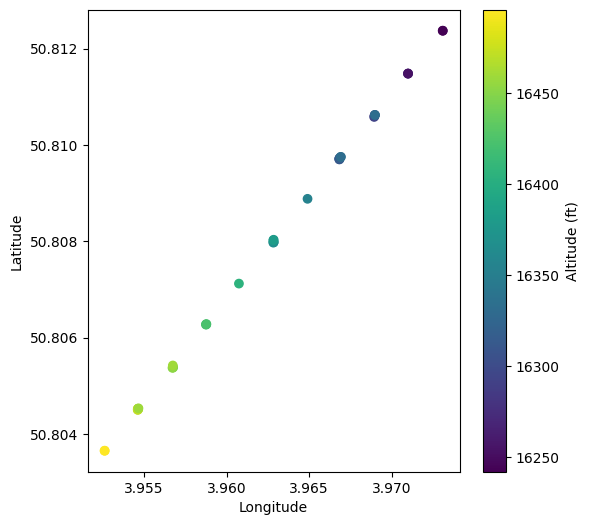

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(flight['lon'], flight['lat'], c=flight['altitude'], cmap='viridis')
plt.colorbar(label='Altitude (ft)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

3. Définition de métriques

In [ ]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 323 to 5704
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          44 non-null     object        
 1   registration  43 non-null     object        
 2   altitude      43 non-null     float64       
 3   velocity      42 non-null     float64       
 4   heading       41 non-null     float64       
 5   lat           40 non-null     float64       
 6   lon           39 non-null     float64       
 7   timestamp     44 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 3.1+ KB


In [ ]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,43.00000,42.000000,41.000000,40.000000,39.000000,44
mean,16001.55814,337.476190,54.756098,50.787646,3.962460,2025-11-19 14:46:38.996045568
min,164.00000,336.000000,5.000000,50.000000,3.952620,2025-11-19 14:46:11.166000
25%,16316.50000,337.000000,56.000000,50.805160,3.956740,2025-11-19 14:46:16.469499904
50%,16367.00000,337.000000,56.000000,50.807980,3.962850,2025-11-19 14:46:36.394000128
75%,16451.00000,338.000000,56.000000,50.809958,3.967925,2025-11-19 14:47:01.085250048
max,16496.00000,343.000000,56.000000,50.812370,3.973080,2025-11-19 14:47:17.269000
std,2473.87537,1.194256,7.964862,0.127760,0.006433,NaN


In [ ]:
# Définition d'un seuil de déviation inquiétant :

def calculate_bearing(lat1, lon1, lat2, lon2, time1, time2):

    """
    On calcule la déviation en degrés, et on ajuste ensuite avec une normalisation
    en fonction de l'intervalle de temps delta_t écoulé entre time1 et time2.
    On calcule ensuite la déviation, on multiplie par delta_t et on divise par 20s
    pour obtenir la déviation moyenne sur les 20 secondes.
    """

    delta_t=(time2-time1).total_seconds()
    if(delta_t==0):
        return 0

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    d_lon = lon2 - lon1
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(d_lon)
    bearing = np.degrees(np.arctan2(x, y))
    return ((bearing + 360) % 360) * delta_t / 20

In [ ]:
# Définition de nouvelles colonnes pour étudier la position précédente
flight['prev_lat']=flight['lat'].shift(1)
flight['prev_lon']=flight['lon'].shift(1)
flight['prev_timestamp']=flight['timestamp'].shift(1)
flight['bearing_20s'] = flight.apply(
    lambda row: calculate_bearing(
        row['prev_lat'], row['prev_lon'],
        row['lat'], row['lon'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_lat']) else None,
    axis=1
)
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 323 to 5704
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            44 non-null     object        
 1   registration    43 non-null     object        
 2   altitude        43 non-null     float64       
 3   velocity        42 non-null     float64       
 4   heading         41 non-null     float64       
 5   lat             40 non-null     float64       
 6   lon             39 non-null     float64       
 7   timestamp       44 non-null     datetime64[ns]
 8   prev_lat        39 non-null     float64       
 9   prev_lon        38 non-null     float64       
 10  prev_timestamp  43 non-null     datetime64[ns]
 11  bearing_20s     33 non-null     float64       
dtypes: datetime64[ns](2), float64(8), object(2)
memory usage: 4.5+ KB
